In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from Technic.data import DataManager
from Technic.model import ModelBase
from Technic.scenario import ScenManager
from Technic.internal import TimeSeriesLoader, PanelLoader
from Technic.mev import MEVLoader


In [2]:
# Create test data for time series
def create_test_timeseries_data():
    # Create historical data (monthly)
    dates = pd.date_range("2020-01-01", "2023-12-31", freq="M")
    historical = pd.DataFrame({
        "target": np.sin(np.arange(len(dates)) * 0.2) * 10 + 100,  # Sinusoidal pattern
        "feature1": np.random.normal(0, 1, len(dates)),
        "feature2": np.random.normal(0, 1, len(dates))
    }, index=dates)
    
    # Create scenario data (monthly)
    scen_dates = pd.date_range("2024-01-01", "2025-12-31", freq="M")
    
    # Base scenario - continuing trend
    base_scen = pd.DataFrame({
        "target": np.sin(np.arange(len(scen_dates)) * 0.2 + len(dates) * 0.2) * 10 + 100,
        "feature1": np.random.normal(0.5, 1, len(scen_dates)),
        "feature2": np.random.normal(0.5, 1, len(scen_dates))
    }, index=scen_dates)
    
    # Adverse scenario - declining trend
    adverse_scen = pd.DataFrame({
        "target": np.sin(np.arange(len(scen_dates)) * 0.2 + len(dates) * 0.2) * 10 + 90,
        "feature1": np.random.normal(-0.5, 1, len(scen_dates)),
        "feature2": np.random.normal(-0.5, 1, len(scen_dates))
    }, index=scen_dates)
    
    return historical, {"Base": base_scen, "Adverse": adverse_scen}

# Create test data for panel data
def create_test_panel_data():
    # Create historical data
    dates = pd.date_range("2020-01-01", "2023-12-31", freq="M")
    entities = [1, 2, 3]  # 3 entities
    
    historical_data = []
    for entity in entities:
        entity_data = []
        for date in dates:
            entity_data.append({
                "entity_id": entity,
                "date": date,
                "target": np.sin(date.month/12 * np.pi) * 10 + 100 + entity * 5,
                "feature1": np.random.normal(0, 1),
                "feature2": np.random.normal(0, 1)
            })
        historical_data.extend(entity_data)
    
    historical = pd.DataFrame(historical_data)
    
    # Create scenario data
    scen_dates = pd.date_range("2024-01-01", "2025-12-31", freq="M")
    
    # Base scenario
    base_data = []
    for entity in entities:
        for date in scen_dates:
            base_data.append({
                "entity_id": entity,
                "date": date,
                "target": np.sin(date.month/12 * np.pi) * 10 + 100 + entity * 5,
                "feature1": np.random.normal(0.5, 1),
                "feature2": np.random.normal(0.5, 1)
            })
    base_scen = pd.DataFrame(base_data)
    
    # Adverse scenario
    adverse_data = []
    for entity in entities:
        for date in scen_dates:
            adverse_data.append({
                "entity_id": entity,
                "date": date,
                "target": np.sin(date.month/12 * np.pi) * 10 + 90 + entity * 5,
                "feature1": np.random.normal(-0.5, 1),
                "feature2": np.random.normal(-0.5, 1)
            })
    adverse_scen = pd.DataFrame(adverse_data)
    
    return historical, {"Base": base_scen, "Adverse": adverse_scen}


In [3]:
# Mock model class for testing
class MockModel(ModelBase):
    def __init__(self, y_fitted_in=None):
        self.y = pd.Series(name="target")  # Mock target variable
        self.y_fitted_in = y_fitted_in
    
    def predict(self, X):
        # For time series data
        if isinstance(X.index, pd.DatetimeIndex):
            return pd.Series(X['feature1'] * 10 + X['feature2'] * 5 + 100, index=X.index)
        # For panel data
        else:
            return pd.Series(X['feature1'] * 10 + X['feature2'] * 5 + 100, index=X.index)


In [4]:
# Test 1: Time Series Data
print("Test 1: Testing with Time Series Data")
print("-" * 50)

# Create test data
historical, scenarios = create_test_timeseries_data()

# Setup DataManager with TimeSeriesLoader
loader = TimeSeriesLoader(scen_p0="2023-12-31")
loader.load(historical)
loader.load_scens(source=scenarios, set_name="TEST_SET")

mevloader = MEVLoader()
mevloader.load(scenarios['Base'])
mevloader.load_scens(scenarios, set_name="TEST_SET")

dm = DataManager(loader, mevloader)

# Create mock model with fitted values
model = MockModel(y_fitted_in=historical['target'])

# Create ScenManager
scen_mgr = ScenManager(dm, model, ['feature1', 'feature2'], horizon=8)

# Test forecast_df property
print("\nTesting forecast_df property:")
forecast_df = scen_mgr.forecast_df['TEST_SET']
print("\nColumns in forecast_df:", forecast_df.columns.tolist())
print("\nUnique periods:", forecast_df['Period'].unique())
print("\nSample of forecast_df:")
print(forecast_df.head())

# Test plot_forecasts method
print("\nTesting plot_forecasts method:")
figures = scen_mgr.plot_forecasts(
    figsize=(10, 5),
    title_prefix="Time Series Test - ",
    save_path="./test_plots"
)

print("\nNumber of figures created:", len(figures))
print("Figure keys:", list(figures.keys()))


Test 1: Testing with Time Series Data
--------------------------------------------------


e:\OneDrive\Git\Project_LEGO\Technic\mev.py:574: UserWarning: The following MEV codes are not in MEV_MAP: ['feature1', 'feature2', 'target']
Please add them to mev_type.xlsx with appropriate type and description.
  warnings.warn(


TypeError: Can't instantiate abstract class MockModel with abstract methods fit

In [ ]:
# Test 2: Panel Data
print("Test 2: Testing with Panel Data")
print("-" * 50)

# Create test data
historical, scenarios = create_test_panel_data()

# Setup DataManager with PanelLoader
loader = PanelLoader(
    entity_col="entity_id",
    date_col="date",
    scen_p0="2023-12-31"
)
loader.load(historical)
loader.load_scens(source=scenarios, set_name="TEST_SET")

dm = DataManager()
dm._internal_loader = loader
dm.internal_data = historical
dm.scen_internal_data = {"TEST_SET": scenarios}
dm.scen_mevs = {"TEST_SET": scenarios}  # Using same data for MEVs

# Create mock model with fitted values
model = MockModel(y_fitted_in=historical.set_index(['entity_id', 'date'])['target'])

# Create ScenManager
scen_mgr = ScenManager(dm, model, ['feature1', 'feature2'], horizon=8)

# Test forecast_df property
print("\nTesting forecast_df property:")
forecast_df = scen_mgr.forecast_df['TEST_SET']
print("\nColumns in forecast_df:", forecast_df.columns.tolist())
print("\nUnique periods:", forecast_df['Period'].unique())
print("\nSample of forecast_df:")
print(forecast_df.head())

# Test plot_forecasts method with custom styling
print("\nTesting plot_forecasts method with custom styling:")
custom_style = {
    'Base': {'color': 'green', 'linestyle': '-', 'label': 'Base Scenario'},
    'Adverse': {'color': 'orange', 'linestyle': '--', 'label': 'Adverse Scenario'}
}
figures = scen_mgr.plot_forecasts(
    figsize=(12, 6),
    style=custom_style,
    title_prefix="Panel Data Test - ",
    save_path="./test_plots"
)

print("\nNumber of figures created:", len(figures))
print("Figure keys:", list(figures.keys()))


In [ ]:
# Test 3: Verify Period Assignment for Monthly Data
print("Test 3: Verifying Period Assignment for Monthly Data")
print("-" * 50)

# Get the time series forecast DataFrame
ts_forecast_df = scen_mgr.forecast_df['TEST_SET']

# Group by Period and get date ranges
period_ranges = ts_forecast_df.groupby('Period').apply(
    lambda x: pd.Series({
        'Start': x.index.min(),
        'End': x.index.max(),
        'Count': len(x)
    })
)

print("\nPeriod Date Ranges:")
print(period_ranges)

# Verify that months in the same quarter have the same period
def verify_quarter_periods(df):
    df['Quarter'] = df.index.to_period('Q')
    quarter_periods = df.groupby('Quarter')['Period'].nunique()
    print("\nNumber of unique periods per quarter:")
    print(quarter_periods)
    
    if (quarter_periods > 1).any():
        print("\nWARNING: Some quarters have multiple period assignments!")
    else:
        print("\nAll months within each quarter have the same period assignment.")

verify_quarter_periods(ts_forecast_df)


# Test Summary

The test notebook includes three main test cases:

1. **Time Series Data Test**
   - Tests the `forecast_df` property with time series data
   - Verifies proper column structure (Period, Fitted, scenarios)
   - Tests plot generation with default styling
   - Saves plots to `./test_plots` directory

2. **Panel Data Test**
   - Tests the `forecast_df` property with panel data
   - Verifies proper handling of entity-date relationships
   - Tests plot generation with custom styling
   - Demonstrates aggregation of panel data in plots

3. **Period Assignment Verification**
   - Verifies that monthly data is properly assigned to quarterly periods
   - Checks that all months within a quarter have the same period indicator
   - Shows date ranges for each period
   - Validates period assignment consistency

The tests verify:
- Proper data structure in `forecast_df`
- Correct period labeling (Pre-P0, P0, P1, etc.)
- Plot generation and customization
- Handling of both time series and panel data
- Quarterly period assignment for monthly data


# Testing ScenManager Features

This notebook demonstrates the key features of the ScenManager class, including:
1. Basic scenario forecasting
2. Conditional forecasting
3. Different data configurations (MEV-only vs MEV+internal)
4. Error handling for inconsistent data


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from Technic.data import DataManager
from Technic.internal import TimeSeriesLoader
from Technic.model import ModelBase
from Technic.scenario import ScenManager
from Technic.mev import MEVLoader


## 1. Setup Test Data

First, let's create some sample data for testing:


In [2]:
# Create historical data (internal variables only)
dates = pd.date_range('2023-01-01', '2023-12-31', freq='M')
historical = pd.DataFrame({
    # Internal variables (bank-specific metrics)
    'loan_default_rate': np.random.normal(2, 0.3, len(dates)),
    'customer_deposits': np.random.normal(1000, 50, len(dates)),
    'net_interest_margin': np.random.normal(3.5, 0.2, len(dates)),
    'target': np.random.normal(100, 10, len(dates))
}, index=dates)

# Create MEV scenarios (external economic indicators)
forecast_dates = pd.date_range('2024-01-01', '2024-12-31', freq='M')
base_mev = pd.DataFrame({
    'gdp_growth': np.random.normal(2.5, 0.5, len(forecast_dates)),
    'unemployment': np.random.normal(3.8, 0.3, len(forecast_dates)),
    'interest_rate': np.random.normal(3.5, 0.2, len(forecast_dates))
}, index=forecast_dates)

adverse_mev = pd.DataFrame({
    'gdp_growth': np.random.normal(1.5, 0.5, len(forecast_dates)),
    'unemployment': np.random.normal(4.5, 0.3, len(forecast_dates)),
    'interest_rate': np.random.normal(2.5, 0.2, len(forecast_dates))
}, index=forecast_dates)

# Create internal data scenarios (bank-specific metrics)
base_internal = pd.DataFrame({
    'loan_default_rate': np.random.normal(1.8, 0.3, len(forecast_dates)),
    'customer_deposits': np.random.normal(1100, 50, len(forecast_dates)),
    'net_interest_margin': np.random.normal(3.8, 0.2, len(forecast_dates)),
    'target': np.random.normal(110, 12, len(forecast_dates))
}, index=forecast_dates)

adverse_internal = pd.DataFrame({
    'loan_default_rate': np.random.normal(2.5, 0.3, len(forecast_dates)),
    'customer_deposits': np.random.normal(900, 50, len(forecast_dates)),
    'net_interest_margin': np.random.normal(3.2, 0.2, len(forecast_dates)),
    'target': np.random.normal(90, 12, len(forecast_dates))
}, index=forecast_dates)


## 2. Setup DataManager and Loaders

In [3]:
# Create internal loader
internal_loader = TimeSeriesLoader(
    in_sample_start='2023-01-01',
    in_sample_end='2023-12-31',
    scen_p0='2023-12-31'
)

# Load historical data
internal_loader.load(historical)

# Load internal scenarios
internal_loader.load_scens(
    source={
        'CCAR2024': {
            'Base': base_internal,
            'Adverse': adverse_internal
        }
    }
)

# Create MEV loader
mev_loader = MEVLoader()

# Load model MEV data (monthly) - this is where external economic indicators should be
model_mev_df = pd.DataFrame({
    'gdp_growth': np.random.normal(2, 0.5, len(dates)),
    'unemployment': np.random.normal(4, 0.3, len(dates)),
    'interest_rate': np.random.normal(3, 0.2, len(dates))
}, index=dates)
mev_loader.load(source=model_mev_df)  # MEV loader is the proper place for external economic indicators

# Load MEV scenarios
mev_loader.load_scens(
    source={
        'CCAR2024': {
            'Base': base_mev,
            'Adverse': adverse_mev
        }
    }
)

# Create DataManager with both loaders
dm = DataManager(
    internal_loader=internal_loader,
    mev_loader=mev_loader
)


e:\OneDrive\Git\Project_LEGO\Technic\mev.py:574: UserWarning: The following MEV codes are not in MEV_MAP: ['gdp_growth', 'unemployment', 'interest_rate']
Please add them to mev_type.xlsx with appropriate type and description.
  warnings.warn(


## 3. Create a Simple Model for Testing


In [4]:
class SimpleModel(ModelBase):
    def __init__(self, X, y, **kwargs):
        super().__init__(X, y, **kwargs)
        self.coef_ = np.random.randn(X.shape[1])
        
    def fit(self):
        return self
    
    def predict(self, X):
        return pd.Series(
            X @ self.coef_ + np.random.normal(0, 1, len(X)),
            index=X.index,
            name='target'
        )

# Create and fit model
# Combine MEV variables from model_mev and one internal variable
X = pd.concat([
    # MEV variables from model_mev
    dm.model_mev[['gdp_growth', 'unemployment', 'interest_rate']],
    # Single internal variable
    dm.internal_data[['loan_default_rate']]
], axis=1)

model = SimpleModel(
    X=X,
    y=dm.internal_data['target']
).fit()


## 4. Test ScenManager Features


In [5]:
# Create ScenManager
scen_mgr = ScenManager(
    dm=dm,
    model=model,
    specs=['gdp_growth', 'unemployment', 'interest_rate', 'loan_default_rate'],
    target='target'
)

# Test basic properties
print("Available scenario sets:", scen_mgr.scenarios)
print("\nHas conditional specs:", scen_mgr._has_cond)


Available scenario sets: ['CCAR2024']

Has conditional specs: False


### 4.1 Test Simple Forecasting


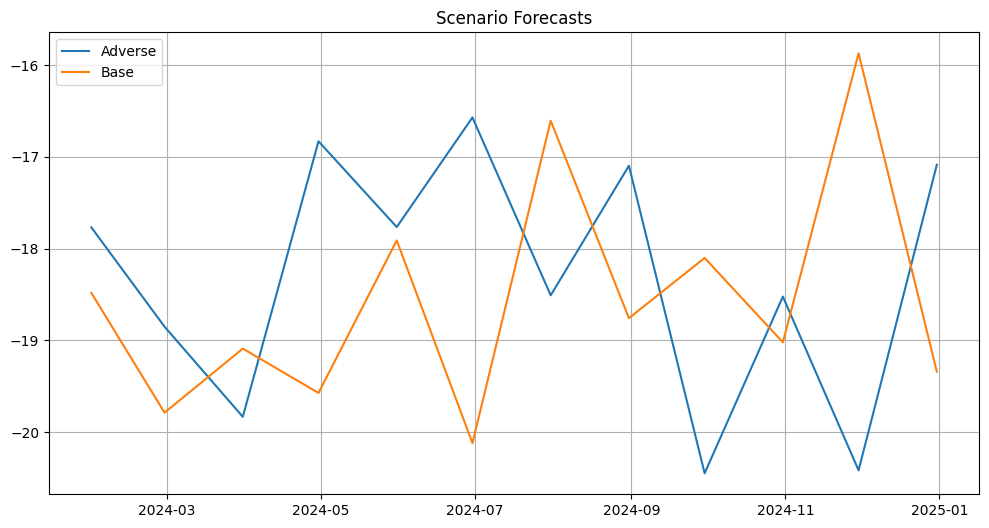

In [6]:
# Get forecasts for all scenarios
forecasts = scen_mgr.y_scens

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for scen_name, forecast in forecasts['CCAR2024'].items():
    plt.plot(forecast.index, forecast.values, label=scen_name)
plt.title('Scenario Forecasts')
plt.legend()
plt.grid(True)
plt.show()


### 4.2 Test MEV-only Scenarios


In [7]:
# Clear internal data scenarios
dm._internal_loader.clean_scens()

# Create new ScenManager with only MEV variables from model_mev
scen_mgr_mev = ScenManager(
    dm=dm,
    model=model,
    specs=['gdp_growth', 'unemployment', 'interest_rate', 'loan_default_rate'],
    target='target'
)

# Get forecasts
forecasts_mev = scen_mgr_mev.y_scens
print("MEV-only forecasts generated successfully")


ValueError: Scenario 'Adverse' in set 'CCAR2024' has empty internal data. Please ensure all scenario internal data is populated with the necessary variables.

In [8]:
dm.scen_mevs['CCAR2024']['Base']

,gdp_growth,unemployment,interest_rate,M,Q
2024-01-31,3.299609,3.833796,3.654537,1,1
2024-02-29,2.149686,3.676281,3.578946,2,1
2024-03-31,2.180040,3.546165,3.586480,3,1
2024-04-30,2.307851,3.924053,3.767273,4,2
2024-05-31,3.000374,3.937894,3.864441,5,2
2024-06-30,2.513250,3.841468,3.502389,6,2
2024-07-31,3.483650,4.719827,3.589928,7,3
2024-08-31,3.266821,3.457821,3.391269,8,3
2024-09-30,1.867205,3.497041,3.600078,9,3
2024-10-31,1.963689,4.092087,3.483039,10,4


In [9]:
scen_mgr_mev.X_scens['CCAR2024']['Base']

X_full:            gdp_growth  unemployment  interest_rate  loan_default_rate
2023-01-31         NaN           NaN            NaN           1.322949
2023-02-28         NaN           NaN            NaN           2.054645
2023-03-31         NaN           NaN            NaN           2.776486
2023-04-30         NaN           NaN            NaN           2.251957
2023-05-31         NaN           NaN            NaN           2.405575
mev_df:            gdp_growth  unemployment  interest_rate  M  Q
2024-01-31    2.187254      4.066900       2.444568  1  1
2024-02-29    2.237274      4.957950       2.771527  2  1
2024-03-31    1.676693      5.134744       2.290984  3  1
2024-04-30    2.243539      4.358950       2.165083  4  2
2024-05-31    2.327633      4.522368       2.503748  5  2
X_full:            gdp_growth  unemployment  interest_rate  loan_default_rate
2023-01-31         NaN           NaN            NaN           1.322949
2023-02-28         NaN           NaN            NaN           2

,gdp_growth,unemployment,interest_rate,loan_default_rate
2023-12-31,NaN,NaN,NaN,1.417173
2024-01-31,3.299609,3.833796,3.654537,NaN
2024-02-29,2.149686,3.676281,3.578946,NaN
2024-03-31,2.180040,3.546165,3.586480,NaN
2024-04-30,2.307851,3.924053,3.767273,NaN
2024-05-31,3.000374,3.937894,3.864441,NaN
2024-06-30,2.513250,3.841468,3.502389,NaN
2024-07-31,3.483650,4.719827,3.589928,NaN
2024-08-31,3.266821,3.457821,3.391269,NaN
2024-09-30,1.867205,3.497041,3.600078,NaN


In [10]:
dm.internal_data

,loan_default_rate,customer_deposits,net_interest_margin,target
2023-01-31,1.322949,945.297600,3.406887,95.719983
2023-02-28,2.054645,982.936508,3.459567,93.815721
2023-03-31,2.776486,1024.819352,3.593300,95.856274
2023-04-30,2.251957,991.144885,3.560416,99.144510
2023-05-31,2.405575,1069.778918,3.297276,102.633790
2023-06-30,1.679306,1082.723373,3.346852,101.055660
2023-07-31,1.783455,980.957028,3.282182,94.699359
2023-08-31,1.945710,962.110696,3.687949,85.791882
2023-09-30,1.793236,908.682551,3.392331,114.987424
2023-10-31,1.991122,934.794191,3.182466,86.715708


### 4.3 Test Error Handling for Inconsistent Data


In [8]:
# Create inconsistent scenario data
dm._internal_loader.clean_scens()
dm._internal_loader.load_scens = {
    'CCAR2024': {
        'Base': base_internal  # Missing Adverse scenario
    }
}

try:
    scen_mgr_inconsistent = ScenManager(
        dm=dm,
        model=model,
        specs=['gdp_growth', 'unemployment', 'interest_rate'],
        target='target'
    )
    forecasts = scen_mgr_inconsistent.y_scens
except ValueError as e:
    print("Expected error caught:")
    print(e)


Expected error caught:
Dot product shape mismatch, (12, 3) vs (4,)


In [12]:
forecasts

{'CCAR2024': {'Adverse': 2024-01-31   -5.119928
  2024-02-29   -7.771170
  2024-03-31   -6.597978
  2024-04-30   -7.682422
  2024-05-31   -5.145370
  2024-06-30   -6.338685
  2024-07-31   -7.720965
  2024-08-31   -7.069795
  2024-09-30   -7.919563
  2024-10-31   -5.757200
  2024-11-30   -7.159447
  2024-12-31   -8.358287
  Freq: M, Name: target, dtype: float64,
  'Base': 2024-01-31   -5.602126
  2024-02-29   -3.698163
  2024-03-31   -4.241413
  2024-04-30   -4.909899
  2024-05-31   -2.814433
  2024-06-30   -4.756073
  2024-07-31   -7.226983
  2024-08-31   -3.170251
  2024-09-30   -5.483752
  2024-10-31   -4.195121
  2024-11-30   -3.110590
  2024-12-31   -5.893073
  Freq: M, Name: target, dtype: float64}}

In [13]:
from Technic.condition import CondVar

# Create conditional specification
cond_spec = CondVar(
    name='lagged_target',
    main_series='target',
    cond_var=['target'],
    lag=1
)

# Create ScenManager with conditional spec
scen_mgr_cond = ScenManager(
    dm=dm,
    model=model,
    specs=['gdp_growth', 'unemployment', 'interest_rate', cond_spec],
    target='target'
)

# Get conditional forecasts
forecasts_cond = scen_mgr_cond.y_scens
print("Conditional forecasts generated successfully")


TypeError: __init__() got an unexpected keyword argument 'name'

In [ ]:
import time

# Test memory usage with property vs attribute
def test_memory_usage():
    # Create large scenario data
    large_dates = pd.date_range('2024-01-01', '2025-12-31', freq='M')
    large_mev = pd.DataFrame(
        np.random.randn(len(large_dates), 50),
        index=large_dates,
        columns=[f'var_{i}' for i in range(50)]
    )
    
    dm.scen_mevs = {'Large': {'Base': large_mev}}
    
    # Time property access
    start_time = time.time()
    X_scens = scen_mgr.X_scens
    end_time = time.time()
    
    print(f"Time to build features: {end_time - start_time:.2f} seconds")
    print(f"Number of scenarios: {len(X_scens)}")
    print(f"Feature matrix shape: {X_scens['Large']['Base'].shape}")

test_memory_usage()
